# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
import time


# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_1st_start = time.time()


# I will fix random seed in following code in several places for reproducibility
random.seed(100)
np.random.seed(100)

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load training, development and test datasets.

train_raw_pd = pd.read_csv("./data_topic/train.csv", header = None)
dev_raw_pd = pd.read_csv("./data_topic/dev.csv", header = None)
test_raw_pd = pd.read_csv("./data_topic/test.csv", header = None)

Then, let us check some samples from training, development, and test datasets.

In [3]:
print("check first ten samples from training dataset\n")
print(train_raw_pd.iloc[:10, 1])
print('\n')

print("check first ten samples from development dataset\n")
print(dev_raw_pd.iloc[:10, 1])
print('\n')

print("check first ten samples from test dataset\n")
print(test_raw_pd.iloc[:10, 1])
print('\n')

check first ten samples from training dataset

0    Reuters - Venezuelans turned out early\and in ...
1    Reuters - South Korean police used water canno...
2    Reuters - Thousands of Palestinian\prisoners i...
3    AFP - Sporadic gunfire and shelling took place...
4    AP - Dozens of Rwandan soldiers flew into Suda...
5    Reuters - Rwandan troops were airlifted on Sun...
6    AP - A bomb exploded during an Independence Da...
7    AFP - Australia's foreign minister will pay a ...
8    AP - Democratic presidential candidate John Ke...
9    AP - Democratic vice presidential candidate Jo...
Name: 1, dtype: object


check first ten samples from development dataset

0    BAGHDAD, Iraq - An Islamic militant group that...
1    Parts of Los Angeles international airport are...
2    AFP - Facing a issue that once tripped up his ...
3    The leader of militant Lebanese group Hezbolla...
4    JAKARTA : ASEAN finance ministers ended a meet...
5    The death toll in the Russian schoolhouse sieg..

Put the raw texts into python lists.

In [4]:
# train_text is a list whose elements are texts in training dataset: [text_1, text_2, ..., text_n]
train_raw = [train_raw_pd.iloc[i, 1] for i in range(train_raw_pd.shape[0])]

# dev_text is a list whose elements are texts in development dataset: [text_1, text_2, ..., text_n]
dev_raw = [dev_raw_pd.iloc[i, 1] for i in range(dev_raw_pd.shape[0])]

# test_text is a list whose elements are texts in test dataset: [text_1, text_2, ..., text_n]
test_raw = [test_raw_pd.iloc[i, 1] for i in range(test_raw_pd.shape[0])]


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [6]:
# a provided function to extract unigrams (or other n-grams) from a input text.

def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
   
    # design a regular expression to extract tokens from a sentence
    token_regexp = re.compile(token_pattern)
   
    # extract all unigrams by tokenizing if they are not in stop_list.
    x_uni = [w for w in token_regexp.findall(str(x_raw).lower(),) if w not in stop_words]
   
    # this is to store the ngrams to be returned
    x = []
   
    if ngram_range[0]==1:
        x = x_uni
   
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
       
        # ignore unigrams
        if n==1: continue
       
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1].
        # Note that x_uni and x_uni[1:] have different lengths
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
   
       
    for n in ngrams:
        for t in n:
            x.append(t)
       
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
       
    return x






In [7]:
# check the extracted unigrams from the first text in training dataset

extract_ngrams(train_raw[0], ngram_range = (1, 1), stop_words = stop_words, vocab = set())

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [8]:
# a provided function to get the vocabulary, document frequency counter, and term frequency counter.

def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
   
   
    tokenRE = re.compile(token_pattern)
   
    #df = Counter()
    df = {}
    #ngram_counts = Counter()
    ngram_counts = {}
    vocab = set()
   
    # iterate through each raw text in the whole training set
    for text in X_raw:
       
        x_ngram = extract_ngrams(text, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
       
        #update document frequencies and ngram count frequencies
        
        for word in x_ngram:
            if word not in ngram_counts:
                ngram_counts[word] = 1
            else:
                ngram_counts[word] += 1
        
        without_duplicate = []
        for word in x_ngram:
            if word not in without_duplicate:
                without_duplicate.append(word)
        
        for word in without_duplicate:
            if word not in df:
                df[word] = 1
            else:
                df[word] += 1
        
        #df.update(list(set(x_ngram)))
        #ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set.
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
   
    # keep the top N most frequent
    if keep_topN>0:
        vocab = [[w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab]]
   
   
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [9]:
# obtain the vocabulary, document frequency, and term frequency of unigrams.

vocab, df, ngram_counts = get_vocab(X_raw = train_raw, ngram_range = (1,1), 
                                    token_pattern = r'\b[A-Za-z][A-Za-z]+\b', 
                                    min_df = 0, keep_topN = 0, stop_words = stop_words)

Then, we need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [10]:
# create 2 dictionaries: (1) id2word: key = word's id, value = word; (2) word2id: key = word, value = word's id
# the size of my vocab, df, and ngram_counts are same because my argument min_df = 0

id2word = dict()
word2id = dict()

for i in range(len(vocab)):
    word = list(df.keys())[i]
    id2word[i] = word
    word2id[word] = i

In [11]:
word2id

{'reuters': 0,
 'venezuelans': 1,
 'turned': 2,
 'out': 3,
 'early': 4,
 'large': 5,
 'numbers': 6,
 'sunday': 7,
 'vote': 8,
 'historic': 9,
 'referendum': 10,
 'either': 11,
 'remove': 12,
 'left': 13,
 'wing': 14,
 'president': 15,
 'hugo': 16,
 'chavez': 17,
 'office': 18,
 'give': 19,
 'him': 20,
 'new': 21,
 'mandate': 22,
 'govern': 23,
 'next': 24,
 'two': 25,
 'years': 26,
 'south': 27,
 'korean': 28,
 'police': 29,
 'used': 30,
 'water': 31,
 'cannon': 32,
 'central': 33,
 'seoul': 34,
 'disperse': 35,
 'least': 36,
 'protesters': 37,
 'urging': 38,
 'government': 39,
 'reverse': 40,
 'controversial': 41,
 'decision': 42,
 'send': 43,
 'more': 44,
 'troops': 45,
 'iraq': 46,
 'thousands': 47,
 'palestinian': 48,
 'prisoners': 49,
 'israeli': 50,
 'jails': 51,
 'began': 52,
 'hunger': 53,
 'strike': 54,
 'better': 55,
 'conditions': 56,
 'israel': 57,
 'security': 58,
 'minister': 59,
 'said': 60,
 'didn': 61,
 'care': 62,
 'starved': 63,
 'death': 64,
 'afp': 65,
 'sporadic':

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [12]:
train_extracted_unigrams = []
dev_extracted_unigrams = []
test_extracted_unigrams = []

# extract unigrams for each text in training dataset
for i in range(len(train_raw)):
    extracted_unigrams = extract_ngrams(x_raw = train_raw[i], ngram_range = (1, 1), stop_words = stop_words,
                                       vocab = set())
    train_extracted_unigrams.append(extracted_unigrams)


# extract unigrams for each text in development dataset
for i in range(len(dev_raw)):
    extracted_unigrams = extract_ngrams(x_raw = dev_raw[i], ngram_range = (1, 1), stop_words = stop_words,
                                       vocab = set())
    dev_extracted_unigrams.append(extracted_unigrams)


# extract unigrams for each text in test dataset
for i in range(len(test_raw)):
    extracted_unigrams = extract_ngrams(x_raw = test_raw[i], ngram_range = (1, 1), stop_words = stop_words,
                                       vocab = set())
    test_extracted_unigrams.append(extracted_unigrams)
    

In [13]:
# Check the extracted unigrams for first document in training dataset
train_extracted_unigrams[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [14]:
# define a function to convert lists of words to lists of indices
def convert_to_indices(extracted_unigrams, word2id, vocab):
    # create a list to store all lists of indices for documents in a dataset
    x_indices = [] 
    
    
    for text in extracted_unigrams:
        # create a list to store list of indices for one document in current dataset
        text_indices = []
        
        for word in text:
            if word in vocab:
                text_indices.append(word2id[word])
        
        x_indices.append(text_indices)
    
    return x_indices


In [15]:
# convert lists of extracted unigrams to list of indices
train_indices = convert_to_indices(train_extracted_unigrams, word2id, vocab)
dev_indices = convert_to_indices(dev_extracted_unigrams, word2id, vocab)
test_indices = convert_to_indices(test_extracted_unigrams, word2id, vocab)


In [16]:
# display the list of indices for the first document in training dataset
train_indices[0]

# the element in this list is the index for corresponding unigram in "word2id" dictionary

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

Put the labels `Y` for train, dev and test sets into arrays: 

In [17]:
train_label = np.array([train_raw_pd.iloc[i, 0] for i in range(train_raw_pd.shape[0])]) - 1
dev_label = np.array([dev_raw_pd.iloc[i, 0] for i in range(dev_raw_pd.shape[0])]) - 1
test_label = np.array([test_raw_pd.iloc[i, 0] for i in range(test_raw_pd.shape[0])]) - 1

convert the labels to one-hot labels:

In [18]:
# define a function "convert_to_one_hot" to convert raw label to one hot encoding label.
def convert_to_one_hot(label_raw):
    label_oh = np.zeros([label_raw.shape[0], 3])
    
    for i in range(label_raw.shape[0]):
        label = label_raw[i]
        label_oh[i, label] = 1
    
    return label_oh


In [19]:
# convert raw labels to one-hot-enconding format:

train_label_oh = convert_to_one_hot(train_label)
dev_label_oh = convert_to_one_hot(dev_label)
test_label_oh = convert_to_one_hot(test_label)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [20]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.2):
    
    # initialize the dictionary W
    W = dict()
    
    # initialize the weight matrix for average embedding layer
    w1 = np.random.uniform(-init_val, init_val, size = [vocab_size, embedding_dim])
    W[0] = w1
    
    # initialize the weight matrix for hidden layer(s) and the output layer
    input_dim = embedding_dim
    output_dims = hidden_dim.copy()
    output_dims.append(num_classes)
    
    for i in range(1, len(hidden_dim) + 1 + 1):
        
        if (len(hidden_dim) == 0):
            # at this time, our network only has embedding layer and output layer
            W[i] = np.random.uniform(-init_val, init_val, size = [input_dim, output_dims[i - 1]])
        
        else:
            # at this time, besides the embedding layer and output layer, our network has some hidden layers
            W[i] = np.random.uniform(-init_val, init_val, size = [input_dim, output_dims[i - 1]])
            
            # update input_dim
            input_dim = output_dims[i - 1]


    return W

# Function "network_weights" could produce weight matrices for 2 or more layers.

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [21]:
def softmax(z):
    # I set z is a column vector. Its shape is n*1.
    
    # initialize the numpy array for sig
    sig = np.zeros_like(z)
    
    # calculate the denominator 
    denominator = 0
    
    row = z.shape[0]
    
    for i in range(row):
        denominator += np.exp(z[i])
    
    for i in range(row):
        sig[i] = np.exp(z[i])/denominator
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [22]:
def categorical_loss(y, y_preds):
    # set y to a column vector. Its shape is n*1.
    
    l = np.sum(-y * np.log(y_preds))
    
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [23]:
def relu(z):
    
    # initialize the numpy array a
    a = np.zeros_like(z)
    
    for i in range(z.shape[0]):
        if z[i] > 0:
            a[i] = z[i]
        else:
            a[i] = 0   
    
    return a
    
def relu_derivative(z):
    
    # initialize the numpy array dz
    dz = np.zeros_like(z)
    
    for i in range(z.shape[0]):
        if z[i] > 0:
            dz[i] = 1
        else:
            dz[i] = 0
    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [24]:
def dropout_mask(size, dropout_rate):
    
    # initialize the dropout_vec
    dropout_vec = np.ones(size)
    
    # randomly produce the positions of zeros
    zero_pos = random.sample(range(0, size), int(size * dropout_rate))
    
    for i in zero_pos:
        dropout_vec[i] = 0
    
    return dropout_vec
    
    

In [25]:
# set the random seed to 2022
random.seed(2022)
np.random.seed(2022)

print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [26]:
def forward_pass(x, W, dropout_rate=0.2):
    # note: all layers will have h, a; the output layer will not have dropout mask and relu is not applied on output
    # layer.
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # (1) compute the output values (h, a, dropout mask vector) from embedding layer
    # In this step:
    #              i. list of indices input is mapped to embedding vector by embedding matrix;
    #              ii. all embedding vectors of all words in input is averaged and followed by a ReLU activation
    # function;
    x_mapped = [] # a list to store the corresponding row in embedding matrix for the indices in list x
    
    for index in x:
        x_mapped.append(W[0][index]) # W[0] is the word embedding weight matrix
    
    h = np.mean(np.array(x_mapped), axis = 0) # compute h for embedding layer
    h_vecs.append(h)
    
    a = relu(h) # pass the h of embedding layer to activation function relu
    a_vecs.append(a)
    
    dropout = dropout_mask(size = a.shape[0], 
                           dropout_rate = dropout_rate) # produce the dropout mask for embedding layer
    dropout_vecs.append(dropout)
    
    
    
    
    
    # (2) compute the output values (h, a, dropout mask vector) for other hidden layers (if have) except embedding 
    # layer and output layer.
    if len(W) > 2:
        for i in range(1, len(W) - 1):
            h = (a * dropout) @ W[i]
            h_vecs.append(h)
            
            a = relu(h)
            a_vecs.append(a)
            
            dropout = dropout_mask(size = a.shape[0],
                                  dropout_rate = dropout_rate)
            dropout_vecs.append(dropout)
    
    
    # (3) compute the output values (h, no a and no dropout mask vector) and prediction vector for output layer.
    h = (a * dropout) @ W[list(W.keys())[-1]]
    h_vecs.append(h)
    
    
    prediction_vec = softmax(h) # compute prediction vector from output layer
    
    
    # produce the out_vals dictionary:
    out_vals['h_vecs'] = h_vecs
    out_vals['a_vecs'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['prediction_vec'] = prediction_vec

    
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [27]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # obtain the layer index for each layer:
    layer_nums = list(W.keys())
    
    # initialize a list to contain the gradient with respect to weights for middle hidden layers.
    grads_hidden = []
    
    
    # I've convert the label - y to one hot encoding form.
    # (1) compute the gradient with respect to weights for output layer:
    grad_out_h = (out_vals['prediction_vec'] - y).reshape(1, -1)
    grad_out_w = (out_vals["a_vecs"][-1] * out_vals["dropout_vecs"][-1]).reshape(-1, 1) @ grad_out_h
    
    # Store the gradient with respect to weighted input "h" for last layer
    # Because the grad_h for last layer is required to compute the grad_h for current layer
    grad_last_h = grad_out_h
    
    # (2) compute the gradient with respect to weights for middle hidden layer (if have) except output layer and 
    # embedding layer; meanwhile, update the weights matrix of these parts.
    
    if len(W) > 2:
        for i in range(2, len(W)):
            grad_h = (grad_last_h @ W[layer_nums[-i+1]].T) * \
                     (relu_derivative(out_vals['h_vecs'][-i])).reshape(1, -1)
            grad_w = (out_vals["a_vecs"][-i] * out_vals["dropout_vecs"][-i]).reshape(-1, 1) @ grad_h
            
            # store the gradient with repect to weight "w" for middle hidden layers
            grads_hidden.append(grad_w)
            
            # update the grad_last_h
            grad_last_h = grad_h
    
    
    # (3) compute the gradient with respect to weights for embedding layer if flag "freeze_emb" is False.
    if freeze_emb == False:
        grad_emb_h = (grad_last_h @ W[layer_nums[1]].T) * \
                     (relu_derivative(out_vals['h_vecs'][0])).reshape(1, -1)
    
    
    
    # update weights matrix
    # (1.1) update the weights matrix which connects the last hidden layer to output layer
    W[layer_nums[-1]] = W[layer_nums[-1]] - lr * grad_out_w
    
    # (2.1) update the weights matrices which contect the middle hidden layers (if have)
    if len(W) > 2:
        for i in range(len(W) - 2):
            W[layer_nums[-(2+i)]] = W[layer_nums[-(2+i)]] - lr * grads_hidden[i]
    
    # (3.1) If flag "freeze_emb" is False, update the embedding matrix
    if freeze_emb == False:
        for index in x:
            W[0][index] = W[0][index] - lr * 1/len(x) * grad_emb_h
            

    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [28]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    # set the random seed to 2022
    random.seed(2022)
    np.random.seed(2022)
    
       
    # initialize a list to contain the training input and training label
    # note: the training label has been converted to one-hot encoding form.
    training_data = list(zip(X_tr, Y_tr))
    dev_data = list(zip(X_dev, Y_dev))
    
    
    
    
    
    # initialize the training and validation loss history list to store the loss for each epoch
    training_loss_history = []
    validation_loss_history = []
    
    # initialize the training loss and validation loss:
    training_loss = 0;
    validation_loss = 0;
    
    for x, y in training_data:
        # obtain the predicted label
        y_pred = forward_pass(x, W, dropout_rate = 0.0)['prediction_vec']
        # compute the training loss by true label and predicted label
        training_loss += categorical_loss(y, y_pred)
        
    training_loss_history.append(training_loss/len(training_data))
    
    
    for x, y in dev_data:
        y_pred = forward_pass(x, W, dropout_rate = 0.0)['prediction_vec']
        validation_loss += categorical_loss(y, y_pred)
    
    validation_loss_history.append(validation_loss/len(dev_data))
    
    
    
    
    
    
    
    #############################################################
    # update the weights and train the model by gradient descent:
    for epoch in range(epochs):
        # randomize the order of training data at the begining of each epoch
        random.shuffle(training_data)
        
        # initialize training_loss and validation_loss after at the begining of each epoch
        training_loss = 0
        validation_loss = 0
        
        
        for x, y in training_data:
            # update the weights for current epoch by using training data
            # Perform the Forward pass to compute the itermediate outputs
            out_vals = forward_pass(x, W, dropout_rate = dropout) # implement dropout for regularization
            
            # Perform the Backward pass to compute the gradients and update all weights
            W = backward_pass(x, y, W, out_vals, lr = lr, freeze_emb = freeze_emb)
        
        
        # compute the training loss after the training of current epoch
        for x, y in training_data:
            # obtain the predicted label
            y_pred = forward_pass(x, W, dropout_rate = 0.0)['prediction_vec'] # set dropout_rate to 0 when evaluating
            # compute the training loss by true label and predicted label
            training_loss += categorical_loss(y, y_pred)
        
        # store the new training_loss to training_loss_history
        training_loss_history.append(training_loss/len(training_data))
        
        
        # compute the validation loss after the training of current epoch
        for x, y in dev_data:
            y_pred = forward_pass(x, W, dropout_rate = 0.0)['prediction_vec'] # set dropout_rate to 0 when evaluating
            validation_loss += categorical_loss(y, y_pred)
        
        # store the new validation loss to validation_loss_history
        validation_loss_history.append(validation_loss/len(dev_data))
        
        
        # print training_loss and validation_loss out if flag "print_progress" is True:
        if print_progress == True:
            print("Epoch {:3d}: training loss: {:.6f}, validation loss: {:.6f}"\
                  .format(epoch + 1, 
                          training_loss_history[epoch + 1], 
                          validation_loss_history[epoch + 1]))
        
        
        # If the value of difference between the previous validation loss and current validation loss
        # is smaller than tolerance value, break the for loop and stop the model training.
        if validation_loss_history[epoch] - validation_loss_history[epoch + 1] < tolerance:
            break;
            

    return W, training_loss_history, validation_loss_history

Define a "plot_loss_history" function to display the change of epoch - loss in learning process. 

In [29]:
# define a function to plot the learning process:

def plot_loss_history(tra_loss_history, val_loss_history, title):
    
    x_value = np.array([i for i in range(len(tra_loss_history))])
    
    plt.figure()
    
    plt.plot(x_value, tra_loss_history, lw = 2, label = "training loss")
    plt.plot(x_value, val_loss_history, lw = 2, label = "validation loss")
    
    
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [30]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_1st_end = time.time()

## Tuning the hyperparameters and choose the best one


Up to now, we have defined all functions we need to train a single model. Then, we should implement a hyperparameters tuning task to choose the best hyperparameters based on their validation accuracies and F-1 score of validation dataset.

Now, I will define a "param_tuning" function to tune the hyperparameters and return the best hyperparameters with the highest model validation accuracy (if there is a tie on validation accuracies, then we choose the parameter combination which help model reach a higher validation F-1 score as the best hyperparameters).

The input arguments include: processed_training_data ("X_tr"), training_label ("Y_tr"), processed_validation_dataset ("X_dev"), validation_label ("Y_dev"), and a parameter_grid ("param_grid") including all hyperparameters which will be tuned and their corresponding candidate values.

There are also some other arguments for "param_tuning" function: "freeze_emb" (whether update the embedding matrix by ourselves), "w_glove", "print_progress" (whether print out the training process).

The candidate parameters which could be tuned including: learning rate, dropout rate, embedding dim, middle hidden layers' structure (for shallow network with randomly generate average embedding matrix and shallow network with pre-trained average embedding matrix, we don't need to choose the best middle hidden layers' structure).

### Define the important "param_tuning" function which could choose the best hyperparameters from candidate combinations:

In [31]:
# Define a "param_tuning" function to return the best hyperparameters.
def param_tuning(X_tr, Y_tr, X_dev, Y_dev, param_grid = {}, freeze_emb = False, w_glove = [], print_progress = False):
    
    # param_grid.keys(): ["learning_rate", "dropout_rate", "embedding_dim", "epoch", layer"]
    # To save some time, I will not tune "tolerance" and set it equal to 0.0001 for all candidate models.
    # We will not print the training process in default.
    
    
    # initialize the best training accuracy and validation accuracy:
    training_acc_best = 0
    validation_acc_best = 0
    validation_f1_best = 0
    
    # initialize the best hyparameter dictionary:
    best_param = {}
    
    for emb_dim in param_grid["embedding_dim"]:
        for layer in param_grid["layer"]:
            for lr in param_grid["learning_rate"]:
                for dropout in param_grid["dropout_rate"]:
                    for epoch in param_grid["epoch"]:
                        # set the random seed
                        random.seed(2022)
                        np.random.seed(2022)
                        
                        # Initialize the weights for network based on current emedding_dim value and layer structure:
                        W = network_weights(vocab_size = len(vocab), embedding_dim = emb_dim,
                                        hidden_dim = layer, num_classes = 3)
                        
                        # if we are tunning parameters for pre-trained model, the flag "freeze_emb" will change to True.
                        if freeze_emb == True:
                            W[0] = w_glove
                        
                        # Train the network with current learning_rate, dropout_rate, and epoch
                        W_updated, tr_loss, val_loss = SGD(X_tr, Y_tr, W, X_dev, Y_dev,
                                              lr = lr,
                                              dropout = dropout,
                                              freeze_emb = freeze_emb,
                                              tolerance = 0.0001,
                                              epochs = epoch,
                                              print_progress = print_progress)
                        
                        # obtain the prediction labels for training data and validation data
                        pred_tr = [np.argmax(forward_pass(x, W_updated, dropout_rate=0.0)['prediction_vec']) 
                                   for x in X_tr]
                        pred_dev = [np.argmax(forward_pass(x, W_updated, dropout_rate = 0.0)['prediction_vec'])
                                    for x in X_dev]
                        
                        # compute the training and validation accuracy for the model with current iteration's params
                        # compute the f1 score for validation dataset for current model
                        training_acc_new = accuracy_score(train_label, pred_tr)
                        validation_acc_new = accuracy_score(dev_label, pred_dev)
                        validation_f1_new = f1_score(dev_label, pred_dev, average='macro')
                        
                        # Print out current parameters combination
                        print("----------------------------------------------------------------------------------")
                        print("Hyperparameters combination and corresponding accuracy: ")
                        print("learning rate = {:.6f}, dropout rate = {:.1f}, epoch = {:3d}, embedding dim = {:3d}, layer structure = {}"\
                             .format(lr, dropout, epoch, emb_dim, layer))
                    
                    
                        # Print out training_accuracy, and validation accuracy for current model
                        print("training accuracy = {:.6f}, validation accuracy = {:.6f}, validation F-1 score = {:.6f}"\
                             .format(training_acc_new, validation_acc_new, validation_f1_new))
                    
                        print(" ")
                        
                        # plot the learning process for the current model
                        plot_loss_history(tr_loss, val_loss, "epoch-loss learning process")
                    
                        # if new validation is larger than the old best validation accuracy, update it.
                        if (validation_acc_new > validation_acc_best):
                            validation_acc_best = validation_acc_new
                            training_acc_best = training_acc_new
                            
                            
                            # update the best hyperparameters:
                            best_param["learning_rate"] = lr
                            best_param["dropout_rate"] = dropout
                            best_param["embedding_dim"] = emb_dim
                            best_param["layer"] = layer
                            best_param["epoch"] = epoch
                            
                        # if new validation accuracy equal to old best validation accuracy,
                        # we compare the validation f1 score.
                        elif (validation_acc_new == validation_acc_best):
                            if (validation_f1_new > validation_f1_best):
                                validation_f1_best = validation_f1_new
                                
                                validation_acc_best = validation_acc_new
                                training_acc_best = training_acc_new
                            
                            
                                # update the best hyperparameters:
                                best_param["learning_rate"] = lr
                                best_param["dropout_rate"] = dropout
                                best_param["embedding_dim"] = emb_dim
                                best_param["layer"] = layer
                                best_param["epoch"] = epoch
    
    
    return best_param
                            
                        

## Tune hyperparameters for shallow network without pre-trained embedding matrix

## (Because this part belongs to parameters tuning part, its running time will not be counted in whole program running time)

Design the parameter grid to store the parameters' candidates.

In [32]:
# parameter grid for shallow network without pre-trained average embedding matrix.
# Here, I decide not tune "epoch" to save some time.

param_grid_shallow = {}
param_grid_shallow["learning_rate"] = [0.003, 0.008]
param_grid_shallow["dropout_rate"] = [0.2, 0.5]
param_grid_shallow["embedding_dim"] = [100, 300]
param_grid_shallow["layer"] = [[]]
param_grid_shallow["epoch"] = [60]

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.003000, dropout rate = 0.2, epoch =  60, embedding dim = 100, layer structure = []
training accuracy = 0.827917, validation accuracy = 0.840000, validation F-1 score = 0.836551
 


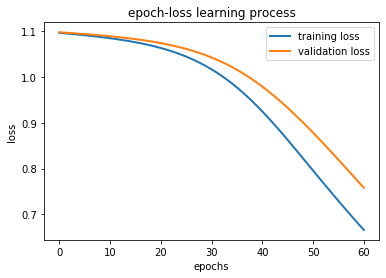

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.003000, dropout rate = 0.5, epoch =  60, embedding dim = 100, layer structure = []
training accuracy = 0.732083, validation accuracy = 0.713333, validation F-1 score = 0.675914
 


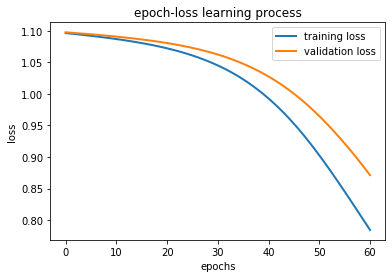

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.008000, dropout rate = 0.2, epoch =  60, embedding dim = 100, layer structure = []
training accuracy = 0.966667, validation accuracy = 0.900000, validation F-1 score = 0.900992
 


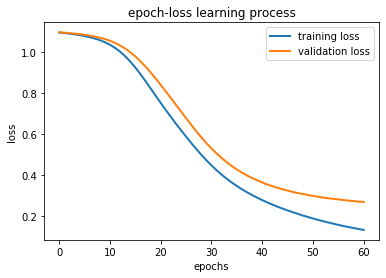

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.008000, dropout rate = 0.5, epoch =  60, embedding dim = 100, layer structure = []
training accuracy = 0.947917, validation accuracy = 0.906667, validation F-1 score = 0.907394
 


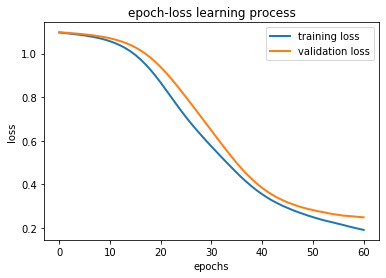

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.003000, dropout rate = 0.2, epoch =  60, embedding dim = 300, layer structure = []
training accuracy = 0.905417, validation accuracy = 0.893333, validation F-1 score = 0.894119
 


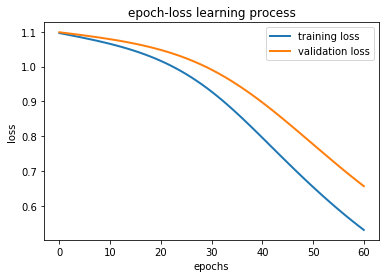

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.003000, dropout rate = 0.5, epoch =  60, embedding dim = 300, layer structure = []
training accuracy = 0.862917, validation accuracy = 0.813333, validation F-1 score = 0.812333
 


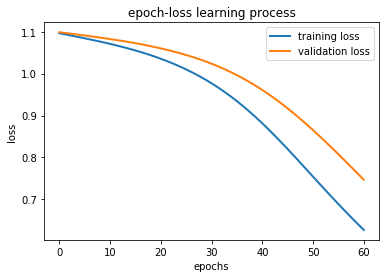

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.008000, dropout rate = 0.2, epoch =  60, embedding dim = 300, layer structure = []
training accuracy = 0.974583, validation accuracy = 0.893333, validation F-1 score = 0.895062
 


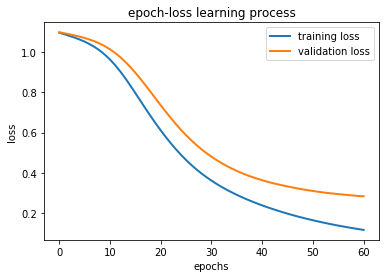

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.008000, dropout rate = 0.5, epoch =  60, embedding dim = 300, layer structure = []
training accuracy = 0.957083, validation accuracy = 0.906667, validation F-1 score = 0.907931
 


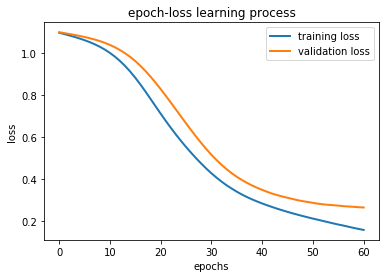

In [33]:
# choose the best hyperparameters for our shallow network (without pre-trained embedding matrix)
best_param_shallow = param_tuning(X_tr = train_indices, Y_tr = train_label_oh,
                                 X_dev = dev_indices, Y_dev = dev_label_oh,
                                 param_grid = param_grid_shallow,
                                 freeze_emb = False,
                                 w_glove = [])

Now you are ready to train and evaluate your neural net by using the best parameters chosen from last step. First, you need to define your network using the `network_weights` function followed by SGD with backprop based on best parameters.:

In [34]:
# display the best hyperparameters chosen by parameter tuning process.
print(best_param_shallow)

{'learning_rate': 0.008, 'dropout_rate': 0.5, 'embedding_dim': 300, 'layer': [], 'epoch': 60}


## Train our simple shallow network without pre-trained embedding matrix by the best hyperparameters (chosen from previous parameters tuning process).

Here, we should have passed the best parameters to our best model programmatically by `embedding_dim` = `best_param_shallow["embedding_dim"]`; `lr` = `best_param_shallow["learning_rate"]`, and `dropout` = `best_param_shallow["dropout_rate"]`.  However, because we fix a random seed, we could obtain the best parameters reproductively (the best params will be exactly same each time when you restart the kernel and run the code), we will mannually pass the best parameter values we found to corresponding parameter like `embedding_dim` = `300`, `lr` = `0.008`, `dropout` = `0.5`

In this way, when you run my code and count the running time, you don't have to run the parameter tuning part and you could use the best parameter I found to run the shallow network without pre-trained emb matrix directly.

You could use programmatically way as I stated above if you want to check whether it is work.

In [35]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_2nd_start = time.time()

In [36]:
# set the random seed to 2022
random.seed(2022)
np.random.seed(2022)

# initialize the weights for shallow network (without pre-trained embedding matrix and middle hidden layers):
W_shallow = network_weights(vocab_size = len(vocab), embedding_dim = 300,
                            hidden_dim = [], num_classes = 3)

# print out the shape of each weights matrix
for i in range(len(W_shallow)):
    print('Shape W{}'.format(W_shallow[i].shape))


Shape W(8931, 300)
Shape W(300, 3)


In [37]:
# train the shallow neural network by "SGD" function:
W_shallow, tr_loss_shallow, val_loss_shallow = SGD(train_indices, train_label_oh,
                                                   W_shallow,
                                                   X_dev = dev_indices, Y_dev = dev_label_oh,
                                                   lr=0.008, 
                                                   dropout=0.5,
                                                   freeze_emb=False,
                                                   tolerance=0.0001,
                                                   epochs=60)

Epoch   1: training loss: 1.089951, validation loss: 1.094661
Epoch   2: training loss: 1.083383, validation loss: 1.090434
Epoch   3: training loss: 1.076490, validation loss: 1.086008
Epoch   4: training loss: 1.069068, validation loss: 1.081290
Epoch   5: training loss: 1.060847, validation loss: 1.076096
Epoch   6: training loss: 1.051695, validation loss: 1.070340
Epoch   7: training loss: 1.041370, validation loss: 1.063961
Epoch   8: training loss: 1.029574, validation loss: 1.056616
Epoch   9: training loss: 1.015968, validation loss: 1.048108
Epoch  10: training loss: 1.000192, validation loss: 1.038207
Epoch  11: training loss: 0.981995, validation loss: 1.026745
Epoch  12: training loss: 0.961105, validation loss: 1.013497
Epoch  13: training loss: 0.937675, validation loss: 0.998447
Epoch  14: training loss: 0.911090, validation loss: 0.980992
Epoch  15: training loss: 0.881862, validation loss: 0.961206
Epoch  16: training loss: 0.850010, validation loss: 0.938834
Epoch  1

Plot the learning process to show the validation loss and training loss of the model trained with best parameters:

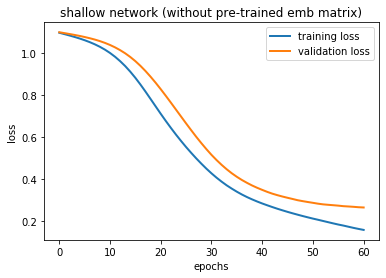

In [38]:
plot_loss_history(tr_loss_shallow, val_loss_shallow, "shallow network (without pre-trained emb matrix)")

report the training accuracy and validation accuracy by using the trained model:

In [39]:
# prediction results for training data by using the trained shallow network without pre-trained emb matrix
preds_tr_shallow = [np.argmax(forward_pass(x, W_shallow, dropout_rate = 0.0)['prediction_vec'])
                    for x in train_indices]

# preidction results for validation data
preds_val_shallow = [np.argmax(forward_pass(x, W_shallow, dropout_rate = 0.0)['prediction_vec'])
                    for x in dev_indices]

# report the training accuracy and validation accuracy
print("Train Accuracy: {}".format(accuracy_score(train_label, preds_tr_shallow)))
print("Validation Accuracy: {}".format(accuracy_score(dev_label, preds_val_shallow)))


Train Accuracy: 0.9570833333333333
Validation Accuracy: 0.9066666666666666


### Discuss the training performance:

From observing above loss-epoch figure, I think this model is trained well.

1. This model is not underfitted, because the final validation loss is very low (0.2655) and the validation loss curve begin to be flat at the end of training. Additionally, we could find in above evaluation (for validation and training data) and in the following evaluation (for test data), the test accuracy of this trained model could reach 85.22% (high enough) and the validation accuracy could reach 90.67%. Both the validation accuracy and test accuracy are high enough to show the model is trained enough and is not underfitted.

2. This model is also not overfitted. The final difference between the validation loss and training loss of training process is small enough (0.2655 - 0.1588 = 0.1067). Both the final validation loss and training loss are low enough. The validation accuracy (90.76%), test accuracy (85.22%) and training accuracy(95.71%) are roughly in the same level. All of these mean the model doesn't only learn how to classify texts for training data well. What the model learn is generalized enough to help the model to classify those unseen texts well.

Compute accuracy, precision, recall and F1-Score:

In [40]:
# obtain the prediction results for test data
preds_te_shallow = [np.argmax(forward_pass(x, W_shallow, dropout_rate = 0.0)['prediction_vec'])
                    for x in test_indices]


print('Test Accuracy:', accuracy_score(test_label, preds_te_shallow))
print('Test Precision:', precision_score(test_label, preds_te_shallow, average='macro'))
print('Test Recall:', recall_score(test_label, preds_te_shallow, average='macro'))
print('Test F1-Score:', f1_score(test_label, preds_te_shallow, average='macro'))

Test Accuracy: 0.8522222222222222
Test Precision: 0.8550013327083391
Test Recall: 0.8522222222222222
Test F1-Score: 0.8519739050195422


### Discuss how did you choose model hyperparameters ? 

I have implemented the hyperparameters tuning process for the shallow network without pre-trained embedding matrix for parameters choosing in above. Here, I will discuss this process in detailed and show a table to display my hyperparameters tuning work.

In the validation process (parameter choosing part), I designed a `param_tuning` function which could train the model by using parameters combinations in a `parameter_grid`. After each training, we could evaluate each model with different parameters by using training dataset and validation dataset. First, I will compare the validation accuracies of these models, the parameters combination could help model reach highest validation accuracy are the best combination. Then, if there is a tie in the validation accuracy, I will compare their validation F-1 score (higher is better). If both their validation accuracy and validation F-1 score are same, I will choose a set of parameters randomly as the best parameters.


Here, I attach a table to display the models' performance trained with different sets of parameters. I tuned parameters `learning rate`, `dropout rate`, and `embedding dim` here. Therefore, there are totally 8 (2^3) set of parameters combinations.

| index | learning rate | dropout rate  | embedding dim  | epoch  | layer structure | training accuracy | validation accuracy | validation F-1 score |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1| 0.003  | 0.2  | 100  | 60  |  [] | 0.8279  |  0.84 | 0.8366  |
|2| 0.003  | 0.5  | 100  | 60  |  [] | 0.7321  | 0.7133  | 0.6759  |
|3| 0.008  | 0.2  | 100  | 60  |  [] | 0.9667  |  0.9 |  0.901 |
|4| 0.008  | 0.5  | 100  | 60  |  [] |  0.9479 |  0.9067 | 0.9074  |
|5| 0.003  | 0.2  | 300  | 60  |  [] | 0.9054  |  0.8933 |  0.8941 |
|6| 0.003  | 0.5  | 300  | 60  |  [] | 0.8629  | 0.8133  | 0.8123 |
|7| 0.008  | 0.2  | 300  | 60  |  [] |  0.9746 | 0.8933  |  0.8951 |
|8| 0.008  | 0.5  | 300  | 60  |  [] |  0.9571 | 0.9067  | 0.9079  |


According to my rule to choose the best parameters, the 4th and 8th set of parameters both help model reach a validation accuracy of 90.67%. Then, we compare the validation F-1 scores of them and find the 8th parameters combination reach a higher validation F-1 score. So, I choose 8th parameters combination as the best combination and use it to train my best shallow network without pre-trained embedding matrix.


In [41]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_2nd_end = time.time()

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [42]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:])#.astype(np.float32)
                    
                    # because there are some strange strings at the beginning of array, we need to remove them.
                    if emb.shape[0] != 300:
                        emb = emb[1:]
                    emb = emb.astype(np.float32)
                    
                    w_emb[word2id[word]] += emb
                    
                    #w_emb[word2id[word]] +=emb
    return w_emb

## Load the pre-trained glove embedding weights matrix

## (Because this part belongs to pre-trained embedding matrix loading part, its running time will not be counted to the whole running time)

In [43]:
# get the pre-trained "glove" embedding matrix.
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt", word2id)

## Tune hyperparameters for shallow network with pre-trained embedding matrix

## ( Because this part belongs to parameter tuning part, its running time will not be counted in whole running time)

Here, because the pre-trained embedding matrix's dimension is fixed to 300, we are not going to tune the embedding_dim parameters. What we plan to tune is: `"learning_rate"`, `"dropout_rate"`, and `"epoch"`.

In [44]:
# design the parameter grid for shallow network with pretrained embedding matrix.
param_grid_pre = {}
param_grid_pre["layer"] = [[]] # the layer structure is not tuned and is fixed.
param_grid_pre["embedding_dim"] = [300] # the "embedding_dim" is not tuned and is fixed to 300.
param_grid_pre["learning_rate"] = [0.0008, 0.002]
param_grid_pre["dropout_rate"] = [0.2, 0.5] 
param_grid_pre["epoch"] = [30, 80]

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.2, epoch =  30, embedding dim = 300, layer structure = []
training accuracy = 0.885417, validation accuracy = 0.913333, validation F-1 score = 0.913795
 


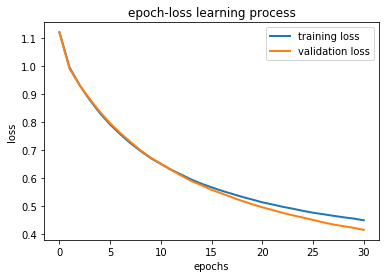

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.2, epoch =  80, embedding dim = 300, layer structure = []
training accuracy = 0.899167, validation accuracy = 0.933333, validation F-1 score = 0.933543
 


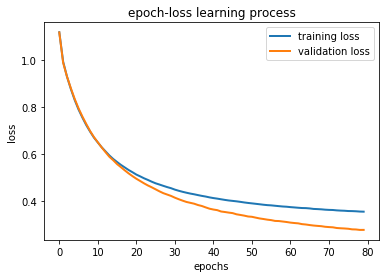

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.5, epoch =  30, embedding dim = 300, layer structure = []
training accuracy = 0.882917, validation accuracy = 0.880000, validation F-1 score = 0.882043
 


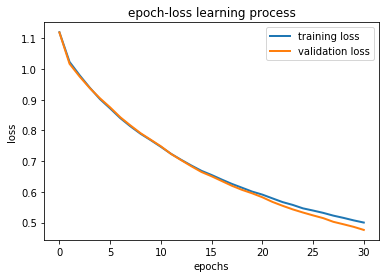

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.5, epoch =  80, embedding dim = 300, layer structure = []
training accuracy = 0.887917, validation accuracy = 0.913333, validation F-1 score = 0.913865
 


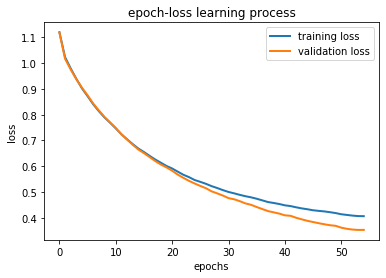

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.002000, dropout rate = 0.2, epoch =  30, embedding dim = 300, layer structure = []
training accuracy = 0.895833, validation accuracy = 0.933333, validation F-1 score = 0.933543
 


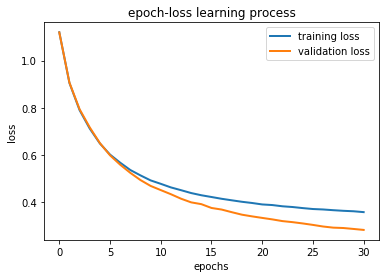

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.002000, dropout rate = 0.2, epoch =  80, embedding dim = 300, layer structure = []
training accuracy = 0.898333, validation accuracy = 0.933333, validation F-1 score = 0.933543
 


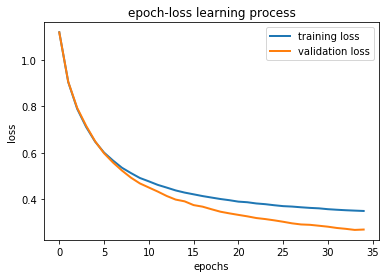

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.002000, dropout rate = 0.5, epoch =  30, embedding dim = 300, layer structure = []
training accuracy = 0.892083, validation accuracy = 0.920000, validation F-1 score = 0.920602
 


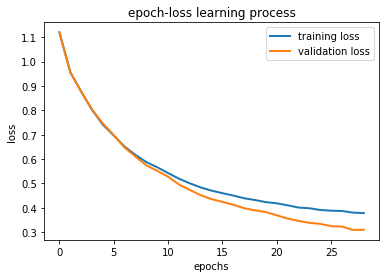

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.002000, dropout rate = 0.5, epoch =  80, embedding dim = 300, layer structure = []
training accuracy = 0.892083, validation accuracy = 0.920000, validation F-1 score = 0.920602
 


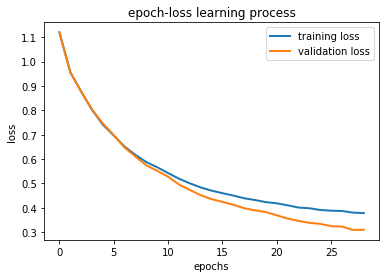

In [45]:
# call the "param_tuning" function to choose the best hyperparameters from the candidate combinations.
# Note, now the flag "freeze_emb" change to True because the embedding matrix is pre-trained and we don't update it
# argument w_glove = w_glove now.
best_param_pre = param_tuning(X_tr = train_indices, Y_tr = train_label_oh,
                                 X_dev = dev_indices, Y_dev = dev_label_oh,
                                 param_grid = param_grid_pre,
                                 freeze_emb = True,
                                 w_glove = w_glove)

In [46]:
# display the best hyperparameters for shallow network with pre-trained average embedding matrix:
print(best_param_pre)

{'learning_rate': 0.002, 'dropout_rate': 0.2, 'embedding_dim': 300, 'layer': [], 'epoch': 30}


## Train our shallow network with pre-trained average embedding matrix by the best hyperparameters (chosen from previous parameters tuning part)

Now, we have gotten the best hyperparamters for the shallow network with pre-trained average embedding matrix. We could use the best parameters to train our network.

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

Similarly, here, we will mannually pass the best parameters to the shallow network with pre-trained embedding matrix like `lr` = `0.002`, `dropout` = `0.2`, and `epoch` = `30`, but not programmatically as `lr` = `best_param_pre["learning_rate"]`, `dropout` = `best_param_pre["dropout_rate"]`, and `epoch` = `best_param_pre["epoch"]`.

In this way, you could run the best model with best parameters I found without running the above parameter tuning part. It will save you time when you run my code and count time.

In [47]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_3rd_start = time.time()

In [48]:
# set the random seed
random.seed(2022)
np.random.seed(2022)

# initialize the weights of my network with pre-trained embedding matrix by using "network_weights" function:
W_pre = network_weights(vocab_size = len(vocab), embedding_dim = 300,
                        hidden_dim = [], num_classes = 3)

# replace the weights of the embedding matrix with w_glove
W_pre[0] = w_glove


In [49]:
# train the new network and freeze the update of embedding weights
W_pre, tr_loss_pre, val_loss_pre = SGD(train_indices, train_label_oh,
                                       W_pre,
                                       X_dev = dev_indices, Y_dev = dev_label_oh,
                                       lr=0.002, 
                                       dropout=0.2,
                                       freeze_emb=True,
                                       tolerance=0.0,
                                       epochs=30)


Epoch   1: training loss: 0.904864, validation loss: 0.906097
Epoch   2: training loss: 0.789560, validation loss: 0.793446
Epoch   3: training loss: 0.711455, validation loss: 0.716485
Epoch   4: training loss: 0.648346, validation loss: 0.649796
Epoch   5: training loss: 0.601042, validation loss: 0.597986
Epoch   6: training loss: 0.566752, validation loss: 0.558188
Epoch   7: training loss: 0.535612, validation loss: 0.523566
Epoch   8: training loss: 0.512806, validation loss: 0.493015
Epoch   9: training loss: 0.491564, validation loss: 0.468121
Epoch  10: training loss: 0.477063, validation loss: 0.450488
Epoch  11: training loss: 0.461812, validation loss: 0.432949
Epoch  12: training loss: 0.450066, validation loss: 0.413882
Epoch  13: training loss: 0.437874, validation loss: 0.398378
Epoch  14: training loss: 0.428572, validation loss: 0.390811
Epoch  15: training loss: 0.421135, validation loss: 0.374651
Epoch  16: training loss: 0.413554, validation loss: 0.367929
Epoch  1

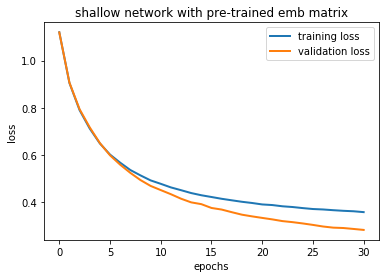

In [50]:
# plot the training loss and validation loss in the training process for shallow network with 
# pre-trained emb matrix.

plot_loss_history(tr_loss_pre, val_loss_pre, "shallow network with pre-trained emb matrix")

report the training accuracy and validation accuracy of the shallow network model (with pre-trained embedding matrix) trained by the best parameters I chose.

In [51]:
# predictions of training data
preds_tr_pre = [np.argmax(forward_pass(x, W_pre, dropout_rate=0.0)['prediction_vec']) 
                for x in train_indices]
# predictions of validation data
preds_val_pre = [np.argmax(forward_pass(x, W_pre, dropout_rate=0.0)['prediction_vec']) 
                for x in dev_indices]

# print out the training and validation accuracy
print('Training Accuracy:', accuracy_score(train_label, preds_tr_pre))
print('Validation Accuracy:', accuracy_score(dev_label, preds_val_pre))

Training Accuracy: 0.8958333333333334
Validation Accuracy: 0.9333333333333333


In [52]:
preds_te_pre = [np.argmax(forward_pass(x, W_pre, dropout_rate=0.0)['prediction_vec']) 
                for x in test_indices]

print('Test Accuracy:', accuracy_score(test_label, preds_te_pre))
print('Test Precision:', precision_score(test_label, preds_te_pre, average='macro'))
print('Test Recall:', recall_score(test_label, preds_te_pre, average='macro'))
print('Test F1-Score:', f1_score(test_label, preds_te_pre, average='macro'))

Test Accuracy: 0.8888888888888888
Test Precision: 0.8892728214496124
Test Recall: 0.888888888888889
Test F1-Score: 0.8889541866971521


### Discuss the training performance of the model with best parameters

Through observing above epoch-loss learning process figure, and the training, validation, and test accuracy, I think the shallow network with pretrained embedding weights is trained well.

1. The model is not underfitted. By checking the figure above, we could find both the final training loss (0.357) and validation loss (0.2815) are low enough at the end of training, and the validation loss curve begins to be flat at the end of training. It means the model has been trained enough and it could do a good job in classification. Both validation accuracy (93.33%) and test accuracy (88.89%) are high enough.

2. The model is not overfitted. By checking the figure above, we could find at the end of training, the validation loss (0.2815) is even lower than the training loss (0.357), and the validation accuracy (93.33%) is even higher than the training accuracy (89.58%). This proves that the model doesn't only learn how to classify the texts in the training dataset. The model also learn well how to classify those unseen texts in validation dataset and test dataset (test accuracy is 88.89% and is very close to training accuracy).

Therefore, the model is not overfitted and underfitted. It is trained pretty well.

### Discuss how did you choose model hyperparameters ? 

The process to choose model's best hyperparameters is similary to previous process for shallow network without pre-trained embedding weights. The main difference is current model will use a pre-trained embedding weights matrix and this matrix has a fixed dimension (300). Therefore, I will not tune the hyperparameter `embedding_dim` this time, I will tune `learning rate`, `dropout rate`, and `epoch`.

Through calling function `"param_tuning"`, we could get our best parameters combination which could help model reach the highest validation accuracy (if there is a tie in validation accuracy, we will compare their validation F-1 score. If both accuracy and F-1 score are the same, we will randomly choose one set of parameters from them as the best.

Here is a table to display the parameters combinations and corresponding performances:

| index | learning rate | dropout rate  | embedding dim  | epoch  | layer structure | training accuracy | validation accuracy | validation F-1 score |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1| 0.0008  | 0.2  | 300  | 30  |  [] | 0.8854  |  0.9133 | 0.9138  |
|2| 0.0008  | 0.2  | 300  | 80  |  [] | 0.8992  | 0.9333  | 0.9335  |
|3| 0.0008  | 0.5  | 300  | 30  |  [] | 0.8829  |  0.88 |  0.882 |
|4| 0.0008  | 0.5  | 300  | 80  |  [] |  0.8879 |  0.9133 | 0.9139  |
|5| 0.002  | 0.2  | 300  | 30  |  [] | 0.8958  |  0.9333 |  0.9335 |
|6| 0.002  | 0.2  | 300  | 80  |  [] | 0.8983  | 0.9333  | 0.9335 |
|7| 0.002  | 0.5  | 300  | 30  |  [] |  0.8921 | 0.92  |  0.9201 |
|8| 0.002  | 0.5  | 300  | 80  |  [] |  0.8921 | 0.92  | 0.9201  |


From observing above table, we could find the 2th, 5th, and 6th parameters combinations have the highest validation accuracies (93.33%) and all their validation accuracies and validation F-1 scores are the same. Therefore, I randomly chose a set of parameters from them three as the best parameters.

### Do I get a better performance when using pre-trained embedding matrix?

The answer is YES. 

Compared to the previous shallow network without pre-trained embedding matrix, the shallow network with a pre-trained embedding matrix could reach a higher validation accuracy and test accuracy. 

Here is a table to display the performances of shallow network with and without pre-trained embedding matrix. Both models are trained by using the best parameters I found by parameter tuning.

| Model | test accuracy |
|:-:|:-:|
|shallow network (without pre-trained)| 85.22%  |
|shallow network (with pre-trained| 88.89%  |

From the table, we could see using pre-trained embedding matrix could improve the performance of network. I will analyze and discuss the reason at the end of the report.

In [53]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_3rd_end = time.time()

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

## Tuning hyperparameters for deeper network with middle hidden layers (with pre-trained embedding matrix)

## ( Because this part belongs to parameter tuning part, its running time will not be counted in whole running time)

Because we use the pre-trained average embedding matrix and this matrix's dimension is fixed, we are not going to tune the parameter "embedding_dim". Here, we will tune a new parameter which was not tuned before - "layer structure". 

To save time, I will fix the parameter "epoch" and only tune the parameter "layer structure", "learning rate", and "dropout_rate".

In [54]:
# design the parameter grid for deeper newtork with middle hidden layers and pre-trained embedding matrix.
param_grid_deep = {}
param_grid_deep["epoch"] = [20] # fix "epoch" and do not tune it
param_grid_deep["embedding_dim"] = [300] # "embedding_dim" is fixed by w_glove and can not be tuned.
param_grid_deep["learning_rate"] = [0.0004, 0.0008]
param_grid_deep["dropout_rate"] = [0.1, 0.3]
param_grid_deep["layer"] = [[200, 100], [200]] # two different candidates for parameter "layer_structure"

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000400, dropout rate = 0.1, epoch =  20, embedding dim = 300, layer structure = [200, 100]
training accuracy = 0.899167, validation accuracy = 0.906667, validation F-1 score = 0.907085
 


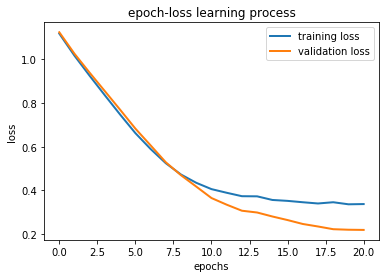

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000400, dropout rate = 0.3, epoch =  20, embedding dim = 300, layer structure = [200, 100]
training accuracy = 0.868750, validation accuracy = 0.860000, validation F-1 score = 0.863057
 


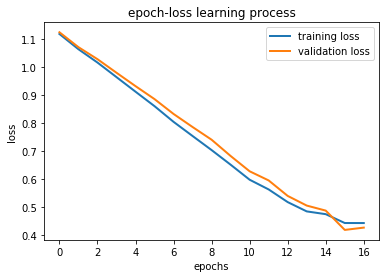

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.1, epoch =  20, embedding dim = 300, layer structure = [200, 100]
training accuracy = 0.902917, validation accuracy = 0.920000, validation F-1 score = 0.920169
 


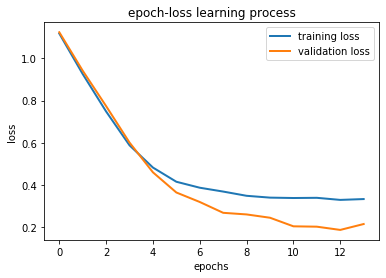

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.3, epoch =  20, embedding dim = 300, layer structure = [200, 100]
training accuracy = 0.885417, validation accuracy = 0.913333, validation F-1 score = 0.914015
 


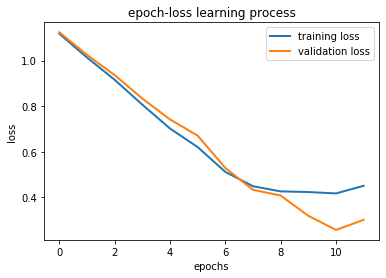

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000400, dropout rate = 0.1, epoch =  20, embedding dim = 300, layer structure = [200]
training accuracy = 0.888333, validation accuracy = 0.913333, validation F-1 score = 0.913044
 


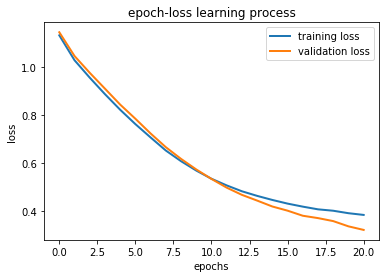

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000400, dropout rate = 0.3, epoch =  20, embedding dim = 300, layer structure = [200]
training accuracy = 0.875417, validation accuracy = 0.880000, validation F-1 score = 0.880819
 


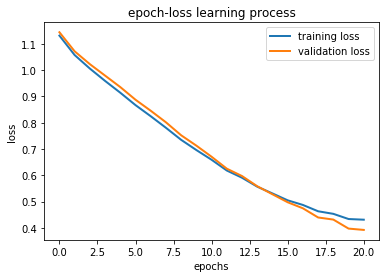

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.1, epoch =  20, embedding dim = 300, layer structure = [200]
training accuracy = 0.899167, validation accuracy = 0.913333, validation F-1 score = 0.914057
 


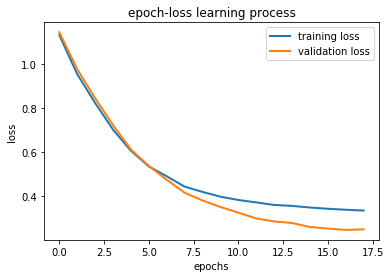

----------------------------------------------------------------------------------
Hyperparameters combination and corresponding accuracy: 
learning rate = 0.000800, dropout rate = 0.3, epoch =  20, embedding dim = 300, layer structure = [200]
training accuracy = 0.880000, validation accuracy = 0.886667, validation F-1 score = 0.887345
 


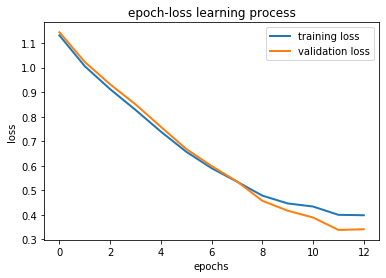

In [55]:
# calling the function "param_tuning" to choose the best hyperparameters from candidate combinations.
# Note, the flag "freeze_emb" is True now, because we use a pre-trained embedding matrix and will not update it.
# argument w_glove = w_glove(pre_trained embedding matrix) now
best_param_deep = param_tuning(X_tr = train_indices, Y_tr = train_label_oh,
                                 X_dev = dev_indices, Y_dev = dev_label_oh,
                                 param_grid = param_grid_deep,
                                 freeze_emb = True,
                                 w_glove = w_glove)


In [56]:
# display the best hyperparameters for deep network with middle hidden layer and pre-trained embedding matrix:
print(best_param_deep)

{'learning_rate': 0.0008, 'dropout_rate': 0.1, 'embedding_dim': 300, 'layer': [200, 100], 'epoch': 20}


## Train our deep network with middle hidden layer and pre-trained average embedding matrix by the best hyperparameters (chosen from previous parameters tuning part)

Similarly, I will mannually pass the best parameters I found to the deep network model (with middle hidden layers anc pre-trained embedding matrix) as following: `hidden_dim` = `[200, 100]`, `dropout` = `0.1`, and `learning rate` = `0.0008`.

I could have use programmatically way like `hidden_dim` = `best_param_deep["layer"]`, `lr` = `best_param_deep["learning_rate"]`, and `dropout` = `best_param_deep["dropout_rate"]`. But by passing best parameters mannually, you don't have to run the parameter tuning part when you check my code and this will save your time.

In [57]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_4th_start = time.time()

In [58]:
# set the random seed
random.seed(2022)
np.random.seed(2022)

# initialize the weights for network with more intermediate hidden layers:
W_deep = network_weights(vocab_size = len(vocab), embedding_dim = 300,
                         hidden_dim = [200, 100], num_classes = 3)

# replace the weights of embedding layer with pre-trained w_glove
W_deep[0] = w_glove



In [59]:
# train the new deeper (with middle hiden layers) network by freezing the update of embedding weights matrix
W_deep, tr_loss_deep, val_loss_deep = SGD(train_indices, train_label_oh,
                                          W_deep,
                                          X_dev = dev_indices, Y_dev = dev_label_oh,
                                          lr=0.0008, 
                                          dropout=0.1,
                                          freeze_emb=True,
                                          tolerance=0.0001,
                                          epochs=20)

Epoch   1: training loss: 0.925888, validation loss: 0.941678
Epoch   2: training loss: 0.748173, validation loss: 0.773648
Epoch   3: training loss: 0.587603, validation loss: 0.600628
Epoch   4: training loss: 0.482123, validation loss: 0.459505
Epoch   5: training loss: 0.414765, validation loss: 0.363832
Epoch   6: training loss: 0.386464, validation loss: 0.318791
Epoch   7: training loss: 0.368240, validation loss: 0.267435
Epoch   8: training loss: 0.348160, validation loss: 0.259750
Epoch   9: training loss: 0.339473, validation loss: 0.244056
Epoch  10: training loss: 0.337654, validation loss: 0.203346
Epoch  11: training loss: 0.338584, validation loss: 0.201629
Epoch  12: training loss: 0.328694, validation loss: 0.186280
Epoch  13: training loss: 0.332665, validation loss: 0.214209


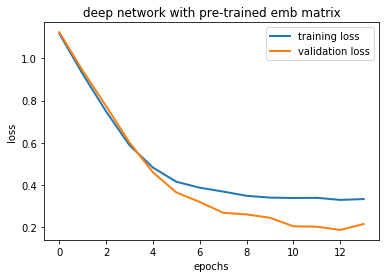

In [60]:
# plot the learning process for deep network (with middle hidden layers and with pre-trained embedding matrix)
plot_loss_history(tr_loss_deep, val_loss_deep, "deep network with pre-trained emb matrix")

Report the training accuracy, validation accuracy, and test performance for the deep network trained by best parameters I found.

In [61]:
# predictions of training dataset and validation dataset:
preds_tr_deep = [np.argmax(forward_pass(x, W_deep, dropout_rate=0.0)['prediction_vec']) 
            for x in train_indices]
preds_val_deep = [np.argmax(forward_pass(x, W_deep, dropout_rate=0.0)['prediction_vec']) 
            for x in dev_indices]
                  
# print out the training and validation accuracy:
print('Training Accuracy:', accuracy_score(train_label ,preds_tr_deep))
print('Validation Accuracy:', accuracy_score(dev_label ,preds_val_deep))

Training Accuracy: 0.9029166666666667
Validation Accuracy: 0.92


In [62]:
# preidction results of test dataset for deep network trained by best parameters
preds_te_deep = [np.argmax(forward_pass(x, W_deep, dropout_rate=0.0)['prediction_vec']) 
            for x in test_indices]

print('Test Accuracy:', accuracy_score(test_label ,preds_te_deep))
print('Test Precision:', precision_score(test_label,preds_te_deep,average='macro'))
print('Test Recall:', recall_score(test_label,preds_te_deep,average='macro'))
print('Test F1-Score:', f1_score(test_label,preds_te_deep,average='macro'))

Test Accuracy: 0.8977777777777778
Test Precision: 0.8973386703133639
Test Recall: 0.8977777777777778
Test F1-Score: 0.8973061106626963


### Discuss the training performance of deep network (with pre-trained embedding matrix and with middle hidden layers)

By observing above figure and training, validation, and test accuracy, I think my deep network trained by best parameters is trained well.

1. It is not underfitted. From figure above, we could find both the validation loss (0.2142) and training loss (0.3327) are low enough at the end of training. And both curves begin to be flat. It means the model is trained enough and the weights (which need to be optimized) are optimized enough. They have the ability to classify texts into right classes with a very high accuracy - training accuracy is 90.29%, validation accuracy is 92%, and test accuracy is 89.78%.

2. This model is also not overfitted. The training accuracy (90.29%), validation accuracy (92%), and test accuracy(89.78%) are very close - almost same. It means the model learned lots of generalized features which could not only help model classify the texts in training dataset, but also help model accurately classify the unseen texts in validation and test dataset. In addition, from the figure, we could see that at the end of training, the validation loss(0.2142) and training loss(0.3327) are very close, too.

So, we could confirm the model is trained very well.

### Discuss how did you choose model hyperparameters for deep network (with pre-trained embedding matrix and middle hidden layers)? 

For the hyperparameter choosing for the deep model, the main difference is that we need to tune a new hyperparameter which is not tuned before. It is `layer_structure`. We need to tune different `layer structures` to find the best one. 

Here, we tune the parameters: `layer`(layer structure), `learning rate`, and `dropout rate`.

The detailed process is similary to previous two models. We call the function `"param_tuning"` to find the best parameters combination from a parameter grid (contain several parameters combinations as candidates).

The parameters combination that could help the model receive highest validation accuracy (if there is a tie in accuracy, then compare the validation F-1 score. If both accuracy and F-1 score are the same, I will randomly choose one from them) is the best parameters combination.

Here is a table to display the parameters combinations and corresponding model performances:

| index | learning rate | dropout rate  | embedding dim  | epoch  | layer structure | training accuracy | validation accuracy | validation F-1 score |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1| 0.0004  | 0.1  | 300  | 20  |  [200, 100] | 0.8992  |  0.9067 | 0.9071  |
|2| 0.0004  | 0.3  | 300  | 20  |  [200, 100] | 0.8688  | 0.86  | 0.8631 |
|3| 0.0008  | 0.1  | 300  | 20  |  [200, 100] | 0.9029  |  0.92 |  0.9202 |
|4| 0.0008  | 0.3  | 300  | 20  |  [200, 100] |  0.8854 |  0.9133 | 0.914  |
|5| 0.0004  | 0.1  | 300  | 20  |  [200] | 0.8883  |  0.9133 |  0.913 |
|6| 0.0004  | 0.3  | 300  | 20  |  [200] | 0.8754  | 0.88  | 0.8808 |
|7| 0.0008  | 0.1  | 300  | 20  |  [200] |  0.8992 | 0.9133  |  0.9141 |
|8| 0.0008  | 0.3  | 300  | 20  |  [200] |  0.88 | 0.8867  | 0.8873  |


From above table, we could find the 3rd parameters combination is the best one. Because this combination could help the deep model get the highest validation accuracy (92%). No more combination could help model reach such a high validation accuracy.


### How does the deeper structure influence performance?

For my own assignment, when I add middle hidden layers to network, the model get a better performance on test data for classification. We could see in below table:

| Model | test accuracy |
|:-:|:-:|
|shallow network (with pre-trained)| 88.89%  |
|deeper network (with pre-trained| 89.78%  |

Above table displays the test accuracy for the deeper network model (with middle hidden layers) and shallow network model (without extra middel hidden layers). Both models are trained by their corresponding best parameters combination which is found by parameter tuning process and both models use a pre-trained embedding matrix.

I will analyze and discuss why deeper network improves performance at the end of the report.

In [63]:
# used to record running time (not include the parameters tuning part and pre-trained embedding matrix loading part)
time_4th_end = time.time()

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.855  |  0.8522 | 0.852  | 0.8522  |
| Average Embedding (Pre-trained)  | 0.8893  | 0.8889  | 0.889  | 0.8889  |
| Average Embedding (Pre-trained) + X hidden layers    | 0.8973  | 0.8978  | 0.8973  | 0.8978  |


### Please discuss why your best performing model is better than the rest.

In my assignment, the best performing model is the `last model (network with pre-trained embedding matrix + [200, 100] middle layers)`.

The reason consists of two parts:

`First part (pre-trained embedding matrix):`

3rd model (pre-trained + [200, 100] hidden layers model) use a pre-trained embedding weights matrix. The "Glove" matrix is trained by a very large dataset with sophisticated skills. It means the weights in "Glove" matrix extract the features of the words in our training dataset well, and these weights in "Glove" matrix could represent these words in our training data well. 

Using this pre-trained embedding weights matrix is much better than randomly initializing and training an embedding weights by our current training data from the scratch. Compared to the dataset which is used to train the pre-trained "Glove" weights matrix, our dataset is very small. 

Therefore, the embedding matrix trained by ourselves can not be as good as the pre-trained one. That is the main reason why both 2nd and 3rd models have a better performance than the 1st model(which is not only shallow, but also without pre-trained embedding matrix)

`Second part (more hidden layers):`

Comparing the 2nd model (shallow and with pre-trained embedding matrix) and 3rd model (deep and with pre-trained embedding matrix), the reason why the 3rd one is better than 2nd one is the 3rd model has more hidden layers.

It means: 

(i) The 3rd model have more weights (roughly $length(vocab)*300 + 300*200 + 200*100 + 100*3$) than the 2nd model (roughly has $length(vocab)*300 + 300*3$ weights). Typically, when the model has more weights, it will have stronger ability to represent the mapping relationship between input (text) and output (class). 

(ii) The 3rd model will have stronger nonlinearity. We use a nonlinear activation function (ReLU) in our network model. When we add more hidden layers, the nonlinearity of deeper network will be stronger than the shallow model. Therefore, the 3rd model (deeper network) could learn more complex mapping relationship between input (text) and output (class) than the shallow models (1st, and 2nd models).

Here is the reason for why the 3rd model (deep network with pre-trained embedding matrix) has the best performance. And why the 2nd model using pretrained matrix is better than the 1st shallow model (without pretrained matrix).


### A brief discussion about text processing choices.

In this assignment, when I extract tokens from a single texts. I choose to remove all punctuations and numbers and only extract those words composed of English letters(a-zA-Z). Then, I use a simple stopword list to remove stopwords from extracted words because I think these words are so common and not informative that these words are not helpful to our model training.

Then, for the size of `vocab`(a python set containing all words used as training features), I decide to set `min_df` to 0 and keep all words extracted from raw texts except those stopwords. Therefore, the `vocab`, dictionary `df`, and dictionary `ngrams_count` have the same size.

### running time (not include hyperparameters tuning and pre-trained matrix loading)

In [64]:
running_time = (time_1st_end - time_1st_start) + (time_2nd_end - time_2nd_start) + \
               (time_3rd_end - time_3rd_start) + (time_4th_end - time_4th_start)

print("The running time on my laptop (Intel Core i7 CPU and 16GB RAM) is {:.6f} seconds".format(running_time))

The running time on my laptop (Intel Core i7 CPU and 16GB RAM) is 191.765449 seconds
